In [7]:
%matplotlib inline

import gc
import time
import fpfs

import numpy as np
import matplotlib.pyplot as plt
import numpy.lib.recfunctions as rfn

In [32]:
def analyze_FPFS(rng:np.random.RandomState, input_shear:np.ndarray, num_gals:int,\
        noi_stds,noi_psf=1e-9) -> tuple[np.ndarray,np.ndarray]:
    noi_stds=   np.array(noi_stds)
    if len(noi_stds.shape)==0:
        noi_stds=np.array([noi_stds])
    elif len(noi_stds.shape)>=2:
        raise ValueError('The input noi_stds should be float or 1d list')
    x       =   []      # SNR
    y       =   []      # estimated shear
    y_err   =   []      # error on shear
    # I am calling this simulation task:
    # https://github.com/mr-superonion/FPFS/blob/188ba8679b4db401129e7504ea5126143bafdee4/fpfs/simutil.py#L163
    testTask=   fpfs.simutil.sim_test(shear=input_shear,rng=rng)
    ngrid   =   testTask.img.shape[0]
    flux_gal=   np.sum(testTask.img[ngrid//2-2:ngrid//2+3,ngrid//2-2:ngrid//2+3])
    ngrid   =   testTask.psf.shape[0]
    rcut    =   16
    beg     =   ngrid//2-rcut
    end     =   beg+2*rcut
    psf     =   testTask.psf[beg:end,beg:end]
    gc.collect()
    num_tests=  noi_stds.size
    for i in range(num_tests):
        noii    =   noi_stds[i]
        x.append(flux_gal/(noii*5))
        # initialize FPFS task with psf and noise variance
        # beta<1 is the FPFS scale parameter
        fpTask  =   fpfs.fpfsBase.fpfsTask(psf,noiFit=noii**2.,beta=0.75)
        if noii<=1e-10:
            print('noise level is too small; therefore, we only simulate one galaxy')
            num_tmp=1
        else:
            num_tmp=num_gals
        start= time.time()
        results =   []
        for _ in range(num_tmp):
            gal =   testTask.make_image(noise=noii,psf_noise=noi_psf)[0]
            ngrid=  gal.shape[0]
            beg =   ngrid//2-rcut
            end =   beg+2*rcut
            gal =   gal[beg:end,beg:end]
            modes=  fpTask.measure(gal)
            results.append(modes)
            del gal,modes,beg,end,ngrid
        end =   time.time()
        print('%.5f seconds to process %d galaxies' %(end-start,num_tmp))
        mms =   rfn.stack_arrays(results,usemask=False)
        ells=   fpfs.fpfsBase.fpfsM2E(mms,const=2000,noirev=False)
        del mms,results
        resp=np.average(ells['fpfs_RE'])
        shear=np.average(ells['fpfs_e1'])/resp
        shear_err=np.std(ells['fpfs_e1'])/np.abs(resp)/np.sqrt(num_gals)
        y.append(shear)
        y_err.append(shear_err)
    return np.array(x),np.array(y), np.array(y_err)

In [34]:
rng     =   np.random.RandomState(212)
noi_stds=   np.logspace(-4, -2, 5, base=10.0)
num_gals=   10000
snr,g1,g1err=   analyze_FPFS(rng,np.array([0.03, 0.00]),num_gals,noi_stds)

2.81993 seconds to process 10000 galaxies
2.76391 seconds to process 10000 galaxies
2.68569 seconds to process 10000 galaxies
2.68631 seconds to process 10000 galaxies
2.69942 seconds to process 10000 galaxies


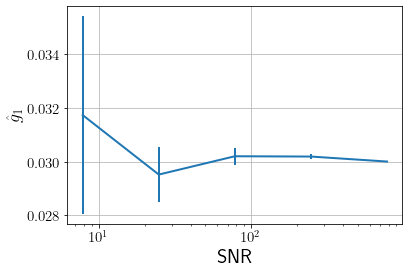

In [38]:
plt.close()
plt.errorbar(snr,g1,g1err)
plt.xlabel('SNR',fontsize=20,weight='bold')
plt.ylabel(r'$\hat{g}_1$')
plt.grid()
plt.xscale('log')

SNR is 26.79


Text(0.5, 1.0, 'SNR=$26.79$')

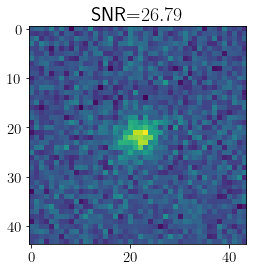

In [46]:
testTask=   fpfs.simutil.sim_test(shear=[0,0],rng=rng)
ngrid   =   testTask.img.shape[0]
flux_gal=   np.sum(testTask.img[ngrid//2-2:ngrid//2+3,ngrid//2-2:ngrid//2+3])
noi_std =   3e-3
print('SNR is %.2f' %(flux_gal/(noi_std*5)))
gal =   testTask.make_image(noise=noi_std,psf_noise=0.)[0]
plt.close()
plt.imshow(gal)
plt.title(r'SNR=$%.2f$'%(flux_gal/(noi_std*5)),fontsize=20)